This is a tutorial pyflowline notebook.
This tutorial is an example of the pyflowline application using a Model for Prediction Across Scales (MPAS) mesh.

The following publication includes a comprehensive application:
Liao, C., Zhou, T., Xu, D., Cooper, M. G., Engwirda, D., Li, H.-Y., & Leung, L. R. (2023). Topological relationship-based flow direction modeling: Mesh-independent river networks representation. Journal of Advances in Modeling Earth Systems, 15, e2022MS003089. https://doi.org/10.1029/2022MS003089

The full documentation is hosted at: https://pyflowline.readthedocs.io

In order the run this notebook, you must install the PyFlowline package and its dependencies. 
Besides, the visulization requires the optional dependency packages (see the full documentation installation section).
You can also modify the notebook to use a different visualization method.


First, let's load some Python libraries.

In [1]:
#step 1
import os
import sys
from pathlib import Path
from os.path import realpath
import importlib
import requests

Then we will check whether some additional packages are installed.

In [ ]:
#check pyflowline installation
iFlag_pyflowline = importlib.util.find_spec("pyflowline") 
if iFlag_pyflowline is not None:
    pass
else:
    print('The pyflowline package is not installed. Please install it following the quickstart document.')

#check optional packages    
iFlag_cython = importlib.util.find_spec("cython")  #check whether cython is installed
iFlag_cartopy = importlib.util.find_spec("cartopy") #check whether cartopy is installed
iFlag_geopandas = importlib.util.find_spec("geopandas") #check whether geopandas is installed
if iFlag_cartopy is not None:
    iFlag_cartopy = 1
    pass
else:
    #if cartopy is not avaialble, we will use the geopanda for visualization
    if iFlag_geopandas is not None:
        pass
    else:
        #if both cartopy and geopandas are not available, we will install the geopandas package under the current environment
        print('We will install the geopandas package for visualization.')
        !conda install --yes --prefix {sys.prefix} gepandas
        iFlag_geopandas = 1
        pass


Now let's define the path of the package.

In [2]:
#step 2, the model needs to know the runtime directory.
#you can either use
#option A: manually specify it
sPath_parent = '/Users/liao313/workspace/python/pyflowline'
print(sPath_parent)

/Users/liao313/workspace/python/pyflowline


In [3]:
#or option B: use python api to locate it
sPath_notebook = Path().resolve()
sPath_parent = str(Path().resolve().parents[0]) 
print(sPath_parent)

/Users/liao313/workspace/python/pyflowline


In [4]:
#Now append this path to the Python path.
sys.path.append(sPath_parent)

We need to download an additional NetCDF file for this example.
This file is stored on the Github release:
https://github.com/changliao1025/pyflowline/releases/tag/0.2.0
https://github.com/changliao1025/pyflowline/releases/download/0.2.0/lnd_cull_mesh.nc

In [ ]:

#download the MPAS mesh from the github release
sFilename_mpas = 'https://github.com/changliao1025/pyflowline/releases/download/0.2.0/lnd_cull_mesh.nc'

#combind folder with filename to get the full path
sFilename_download = os.path.join(sPath_parent, 'mpas_mesh.nc')

# Send an HTTP GET request to the URL
response = requests.get(sFilename_mpas)

# Check if the request was successful
if response.status_code == 200:
    # Save the content of the response to the local file
    with open(sFilename_download, 'wb') as file:
        file.write(response.content)
    print(f"File '{sFilename_download}' downloaded successfully.")
else:
    print(f"Failed to download file from '{sFilename_mpas}'.")

Now we can import a few python function within pyflowline.
The pyflowline python package uses the OOP approach to manage each simulation.

In [5]:
#step 3
#load the read configuration function
from pyflowline.pyflowline_read_model_configuration_file import pyflowline_read_model_configuration_file

pyflowline uses a json file for configuration, an example json file is provided.
check whether a configuration exists

In [6]:
sFilename_configuration_in = realpath( sPath_parent +  '/examples/susquehanna/pyflowline_susquehanna_mpas.json' )
if os.path.isfile(sFilename_configuration_in):
    pass
else:
    print('This configuration does not exist: ', sFilename_configuration_in )

In [7]:
#step 4B(optional)
#we can check what is the content of this json file
import json
with open(sFilename_configuration_in, 'r') as pJSON:
    parsed = json.load(pJSON)
    print(json.dumps(parsed, indent=4))

{
    "sFilename_model_configuration": "/qfs/people/liao313/workspace/python/pyflowline/pyflowline/config/hexwatershed_susquehanna_mpas.json",
    "sWorkspace_data": "/people/liao313/data",
    "sWorkspace_output": "/Users/liao313/tmp",
    "sWorkspace_project": "/hexwatershed/susquehanna",
    "sWorkspace_bin": "/people/liao313/bin",
    "sRegion": "susquehanna",
    "sModel": "pyflowline",
    "sJob": "hex",
    "iFlag_standalone": 1,
    "iFlag_create_mesh": 1,
    "iFlag_mesh_boundary": 1,
    "iFlag_save_mesh": 1,
    "iFlag_simplification": 1,
    "iFlag_intersect": 1,
    "iFlag_flowline": 1,
    "iFlag_use_mesh_dem": 1,
    "iFlag_global": 0,
    "iFlag_multiple_outlet": 0,
    "iFlag_rotation": 0,
    "iCase_index": 1,
    "iMesh_type": 4,
    "dLongitude_left": -79,
    "dLongitude_right": -74.5,
    "dLatitude_bot": 39.2,
    "dLatitude_top": 42.8,
    "dResolution_degree": 5000,
    "dResolution_meter": 5000,
    "sDate": "20220110",
    "sMesh_type": "mpas",
    "sFilename

The meaning of these json keywords are explained in the pyflowline documentation: https://pyflowline.readthedocs.io/en/latest/data/data.html#inputs

For some parameters, we can change them using the following function call.

For some other parameters (e.g., path to file), you need to modify the json file using a text editor.

If the function returns an error, you should update the json file(s). 

Now set up some keywords

In [8]:
#step 5, set up some parameters
sMesh_type = 'mpas'
iCase_index = 1
dResolution_meter=5000
sDate='20230101'

we can now call the function to create an object

In [9]:
#the read function accepts several keyword arguments that can be used to change the default parameters.
#the normal keyword arguments are:
#iCase_index_in: this is an ID to identify the simulation case
#sMesh_type_in: this specifies the mesh type ('mpas' in this example)
#sDate_in: this specifies the date of the simulation, the final output folder will have a pattern such as 'pyflowline20230901001', where pyflowline is model, 20230901 is the date, and 001 is the case index.
oPyflowline = pyflowline_read_model_configuration_file(sFilename_configuration_in, iCase_index_in=iCase_index, 
                                                    sMesh_type_in= sMesh_type, sDate_in=sDate)

/Users/liao313/tmp


In [ ]:
#other than setting the paraemeter using the read model configuration fucntion, user can also change model parameters after creating the model object
#rememere that, it is recommended to set output folder using the read model configuration function since the change_model_parameter function will not update output folder
#only a list of parameters can be changed, for full list, please check the documentation
#in this example, we will change the mesh file name
#the function will check the data type, if incorrect data type is provided, it will raise an error
oPyflowline.change_model_parameter('sFilename_mesh_netcdf', sFilename_download) #because the mpas mesh already contains elevation, we do not need to set the elevation file name
#we will set the boundary file name
#this file should be located in the input folder
sFolder_data = os.path.join(sPath_parent, 'data')
sFolder_data_susquehanna =  os.path.join(sFolder_data, 'susquehanna')
sFolder_input = os.path.join(sFolder_data_susquehanna, 'input')
sFilename_mesh_boundary = os.path.join(sPath_parent, 'boundary_wgs.geojson')
oPyflowline.change_model_parameter('sFilename_boundary_netcdf', sFilename_mesh_boundary)

#we will set the original flowline file name
sFilename_flowline = os.path.join(sFolder_input, 'flowline.geojson')
oPyflowline.change_model_parameter('sFilename_flowline_filtered', sFilename_flowline)

#we can also set for individual basin in the domain, in this example, we only has one basin.
#remember that, each basin can have different parameters, so if you want to set them different (for example, basin 1 has no dam, but basin 2 has dam), you should edit the basin json instead using this function.
#because change_model_parameter will set all the basin using the same parameter in current version
#must set iFlag_basin_in = 1 for basin parameter
oPyflowline.change_model_parameter('iFlag_dam', 0, iFlag_basin_in= 1)





You can review the setting again.

In [10]:
print(oPyflowline.tojson())

{
    "dLatitude_bot": 39.2,
    "dLatitude_top": 42.8,
    "dLongitude_left": -79.0,
    "dLongitude_right": -74.5,
    "dResolution_degree": 5000.0,
    "dResolution_meter": 5000.0,
    "iCase_index": 1,
    "iFlag_break_by_distance": 0,
    "iFlag_create_mesh": 1,
    "iFlag_flowline": 1,
    "iFlag_global": 0,
    "iFlag_intersect": 1,
    "iFlag_mesh_boundary": 1,
    "iFlag_multiple_outlet": 0,
    "iFlag_rotation": 0,
    "iFlag_save_mesh": 1,
    "iFlag_simplification": 1,
    "iFlag_standalone": 1,
    "iFlag_use_mesh_dem": 1,
    "iMesh_type": 4,
    "sCase": "pyflowline20230101001",
    "sDate": "20230101",
    "sFilename_basins": "/Users/liao313/workspace/python/pyflowline/examples/susquehanna/pyflowline_susquehanna_basins.json",
    "sFilename_dem": "/qfs/people/liao313/workspace/python/pyhexwatershed_icom/data/susquehanna/input/dem_buff_ext.tif",
    "sFilename_mesh": "/Users/liao313/tmp/pyflowline20230101001/mpas.geojson",
    "sFilename_mesh_boundary": "/Users/liao313/w

If you are not certain of the outlet location, you can also set them up using:

In [11]:
#another important setting for basin is the approximate outlet location
oPyflowline.aBasin[0].dLatitude_outlet_degree=39.4620
oPyflowline.aBasin[0].dLongitude_outlet_degree=-76.0093
#you can also set it using the change_model_parameter function
oPyflowline.change_model_parameter('dLongitude_outlet_degree', -76.0093, iFlag_basin_in = 1)
oPyflowline.change_model_parameter('dLatitude_outlet_degree', 39.4620, iFlag_basin_in = 1)

You can check the setting for the single basin as well

In [ ]:
print(oPyflowline.aBasin[0].tojson())

After the case object was created, we can set up the model.

In [12]:
#setup the model       
oPyflowline.setup()

Basin 00000001: initial flowline: /Users/liao313/workspace/python/pyflowline/data/susquehanna/input/flowline.geojson


Before any operation, we can visualize the original or raw flowline dataset. 

You can either use your own visualization method to view or map the model output.

For example, if you want to use the built-in function, all you need to provide is a keyword (a look up table is provided in the documentation).
Be default, all the dataset will be converted to the WGS84 system to maintain consistency.
We can take a look at the user-provided flowline.

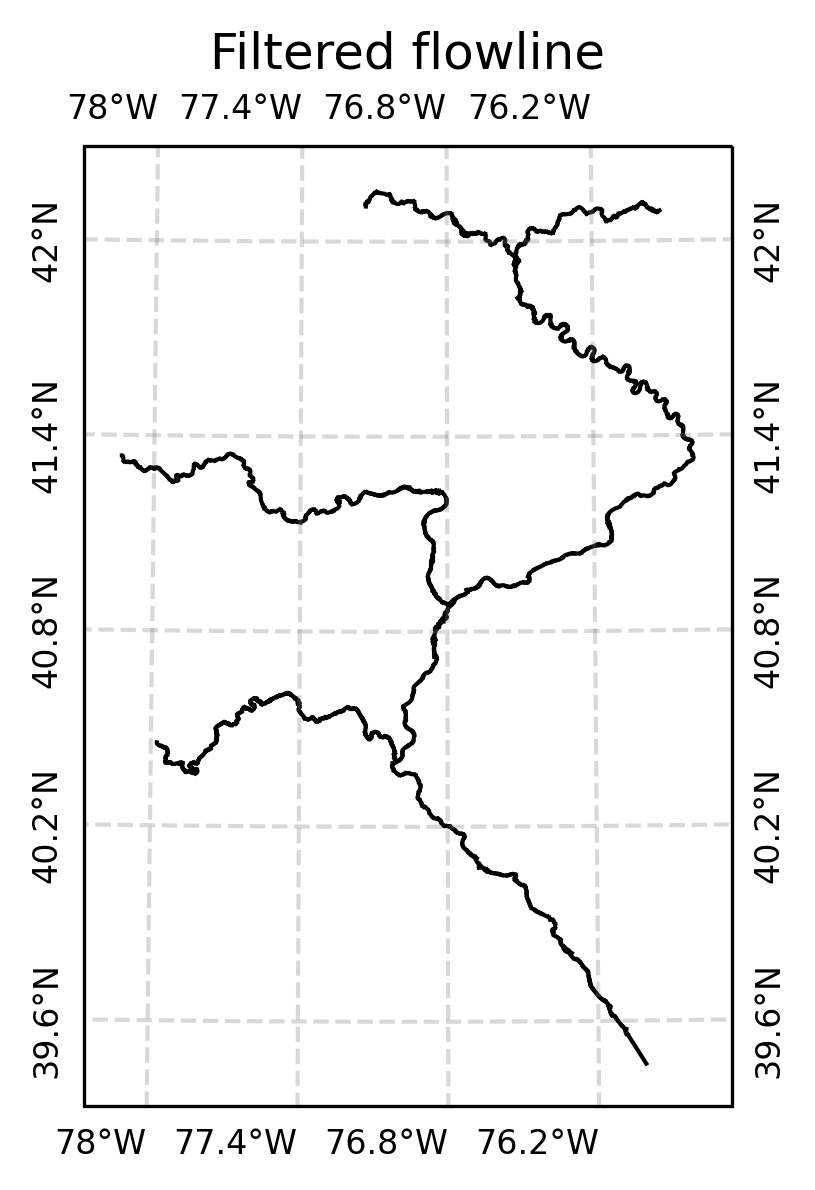

In [13]:

if iFlag_cartopy == 1: # you need to install the geopanda package and matplotlib package using conda or pip
    oPyflowline.plot(sVariable_in = 'flowline_filter' )
    #if you provide a filename, a png file will be saved
    oPyflowline.plot(sVariable_in = 'flowline_filter', sFilename_in = 'filter_flowline.png' )
    pass
else: #use the default visualization method, only experimental
    if iFlag_geopandas == 1:
        import geopandas as gpd
        import matplotlib.pyplot as plt
        #use the geopanda package
        #the raw/original geojson file 
        sFilename_geojson = oPyflowline.aBasin[0].sFilename_flowline_filter_geojson
        gdf = gpd.read_file(sFilename_geojson)
        gdf.plot()
        plt.show()
    else:
        print('The visulization packages are not installed.')
    pass
    

You can also use QGIS or other Python libraries such as GeoPandas.

In [ ]:
#the raw/original geojson file 
sFilename_geojson = oPyflowline.aBasin[0].sFilename_flowline_filter_geojson


The plot function provides a few optional arguments such as map projection and spatial extent. 
By default, the spatial extent is full. 
But you can set the extent to a zoom-in region.

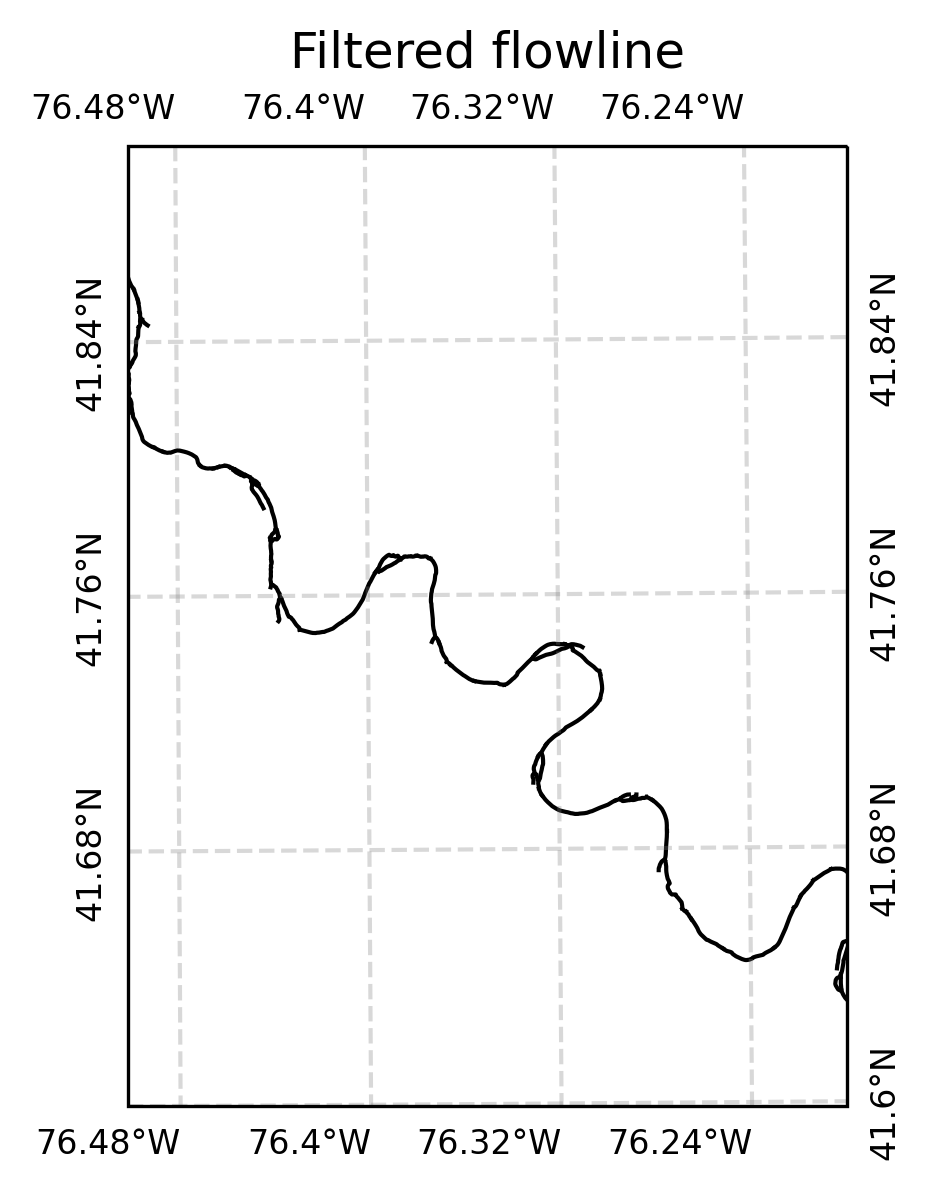

In [14]:

#the default visualization method has an option to set the extent you want to plot
if iFlag_cartopy ==1:
    #aExtent_full = [-78.5,-75.5, 39.2,42.5]
    aExtent_meander = [-76.5,-76.2, 41.6,41.9] 
    oPyflowline.plot( sVariable_in = 'flowline_filter', aExtent_in = aExtent_meander  )

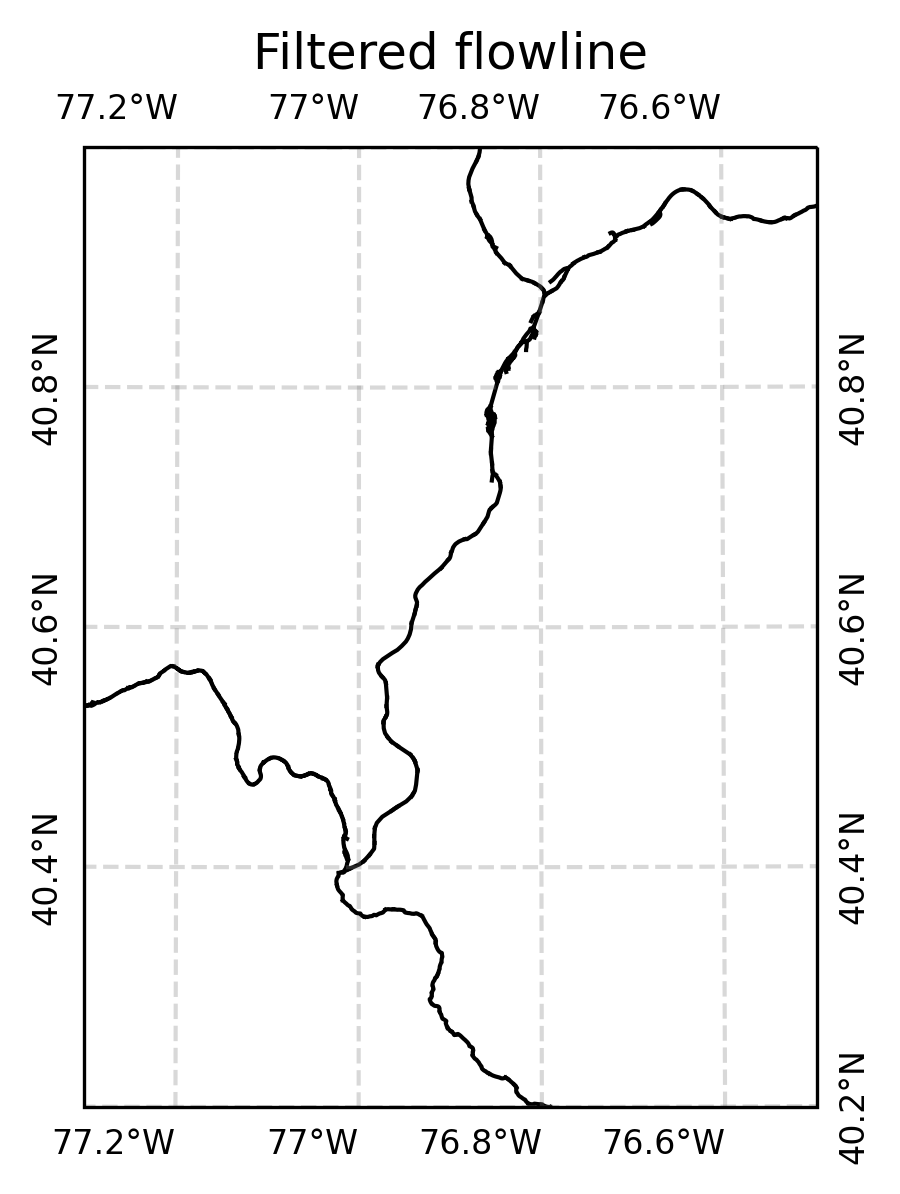

In [15]:
if iFlag_cartopy ==1:
    aExtent_braided = [-77.3,-76.5, 40.2,41.0]  
    oPyflowline.plot( sVariable_in='flowline_filter' , aExtent_in =aExtent_braided ) 

now let's run the three major steps/operations one by one.

In [16]:
#run step 1
oPyflowline.flowline_simplification();

Start flowline simplification: 00000001
Basin  00000001  has no dam
Elapsed time: 3.3879 seconds
Elapsed time: 37.4858 seconds
Basin  00000001 split flowline 1255 1255
Elapsed time: 15.0011 seconds
Basin  00000001 flow direction 1255 1255
Elapsed time: 3.8982 seconds
Elapsed time: 23.7717 seconds
Elapsed time: 0.0001 seconds
Elapsed time: 0.0000 seconds
Elapsed time: 0.0004 seconds
Finish flowline simplification: 00000001


and check the result using a plot

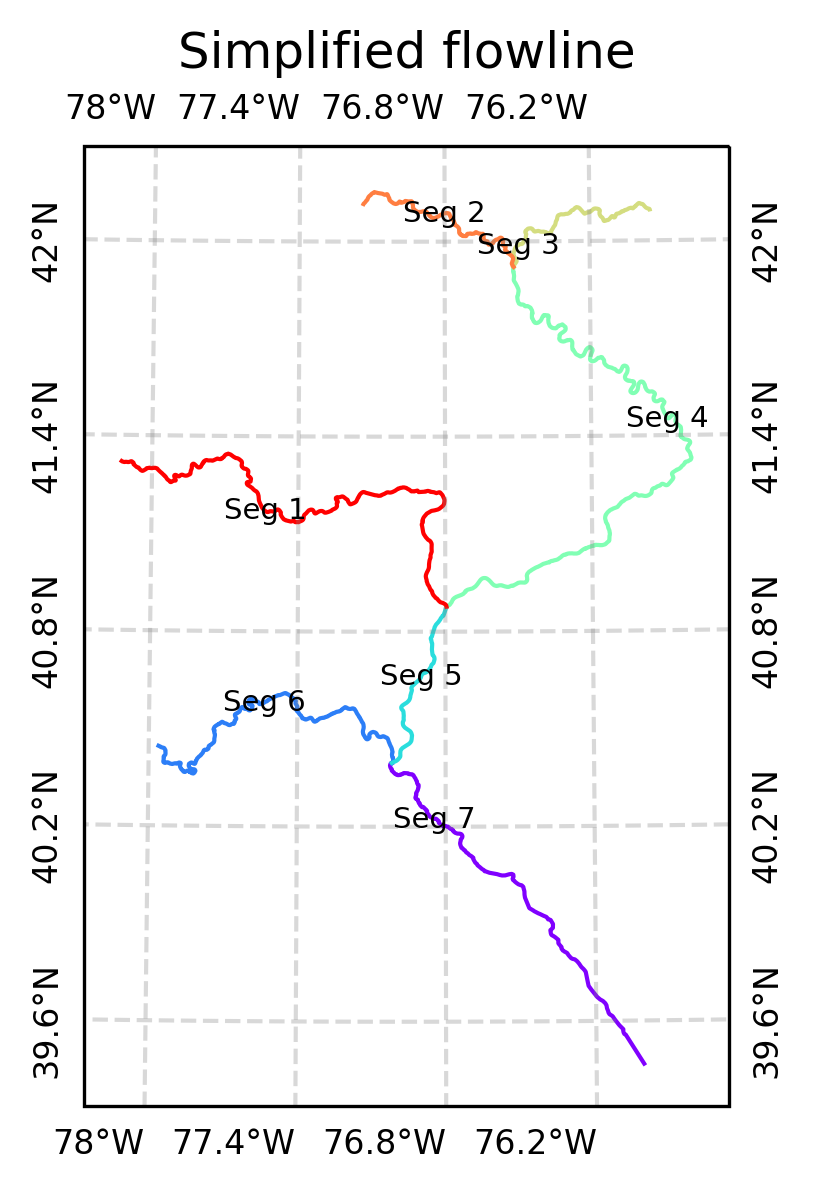

In [17]:

if iFlag_cartopy == 1: # use the default visualization method, only experimental
    oPyflowline.plot( sVariable_in='flowline_simplified' ) 

else: 
      
    import geopandas as gpd
    import matplotlib.pyplot as plt
    #use the geopanda package
    #the raw/original geojson file 
    sFilename_geojson = oPyflowline.aBasin[0].sFilename_flowline_simplified_geojson
    gdf = gpd.read_file(sFilename_geojson)
    gdf.plot()
    plt.show()

    pass

Similarly, we can zoom in using the extent.

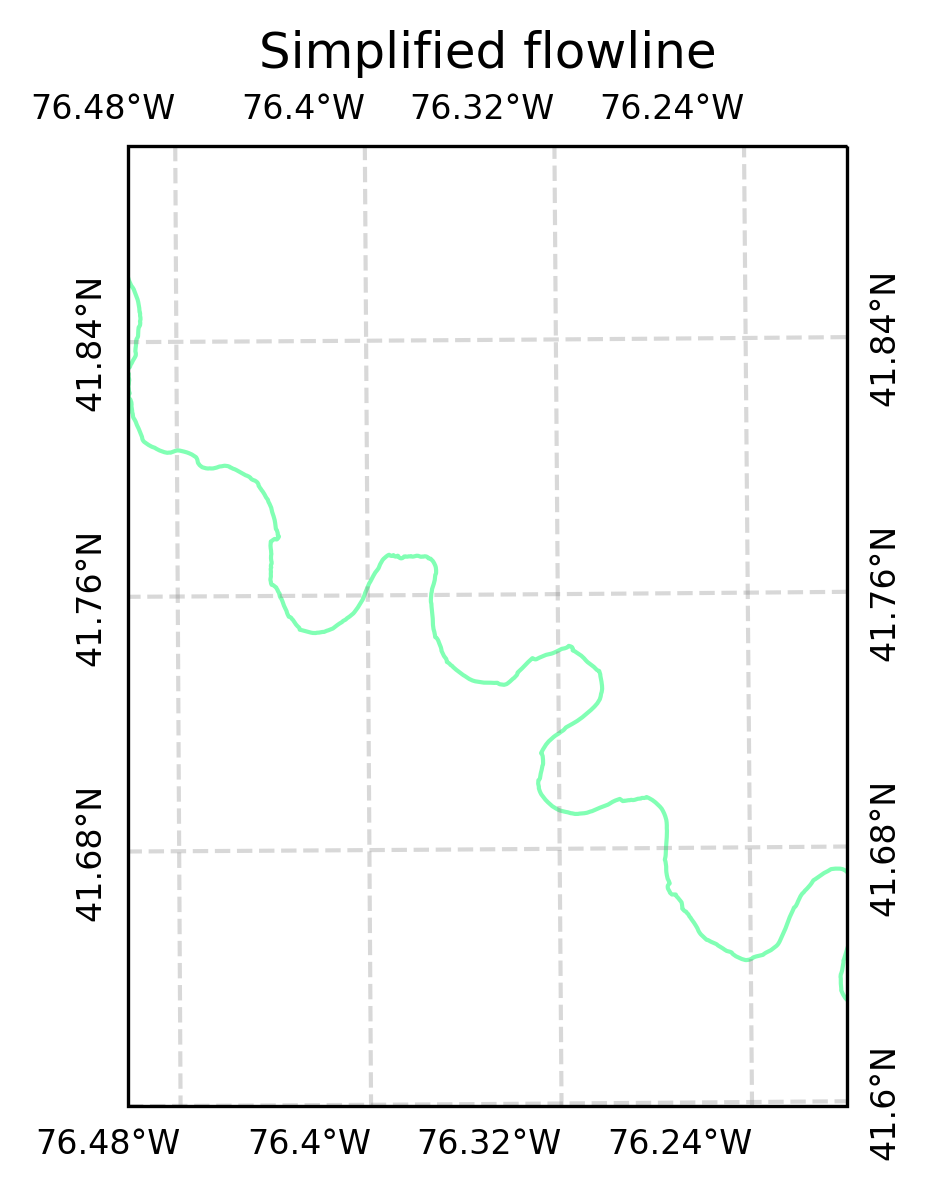

In [18]:
if iVisualization_method == 2:
    aExtent_meander = [-76.5,-76.2, 41.6,41.9] 
    oPyflowline.plot( sVariable_in='flowline_simplified' , aExtent_in =aExtent_meander ) 

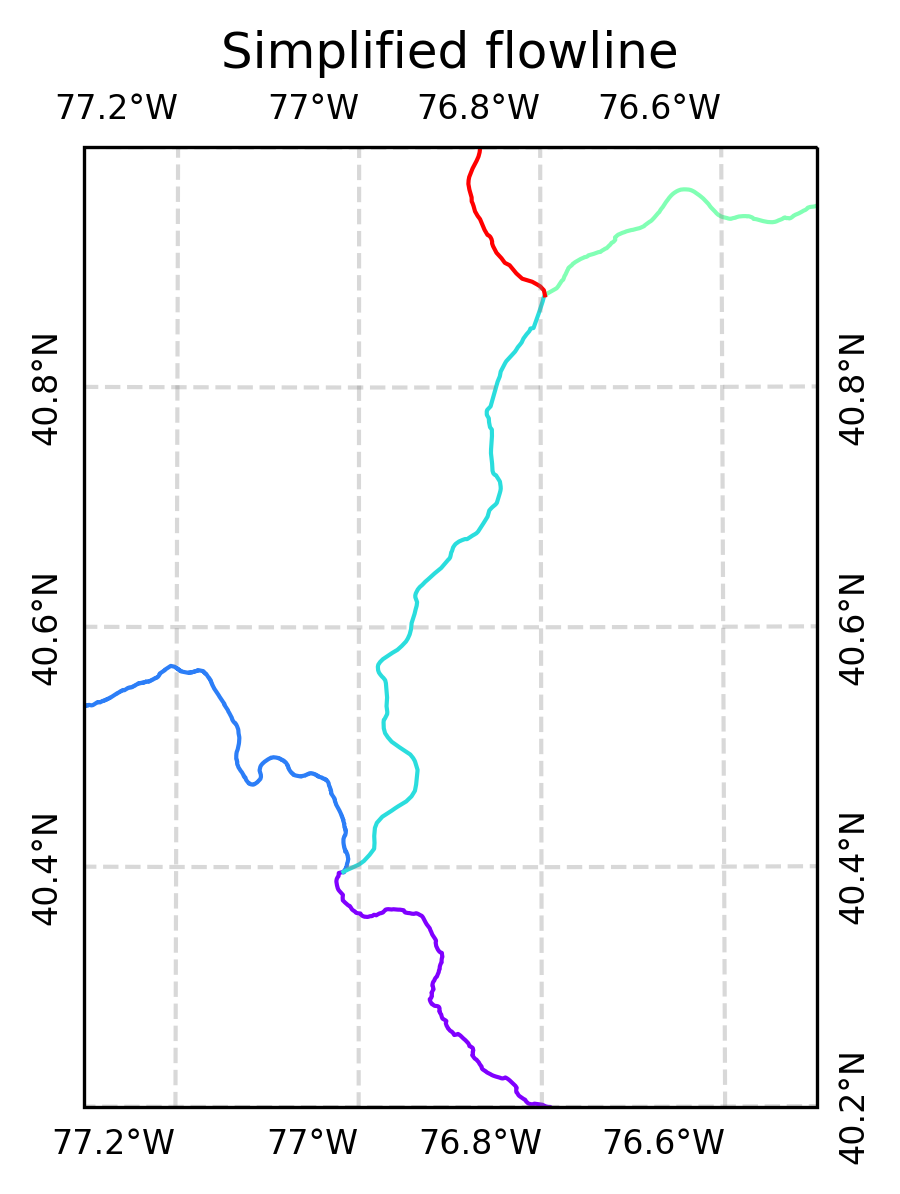

In [19]:
if iVisualization_method == 2:
    aExtent_braided = [-77.3,-76.5, 40.2,41.0] 
    oPyflowline.plot( sVariable_in='flowline_simplified' , aExtent_in =aExtent_braided ) 

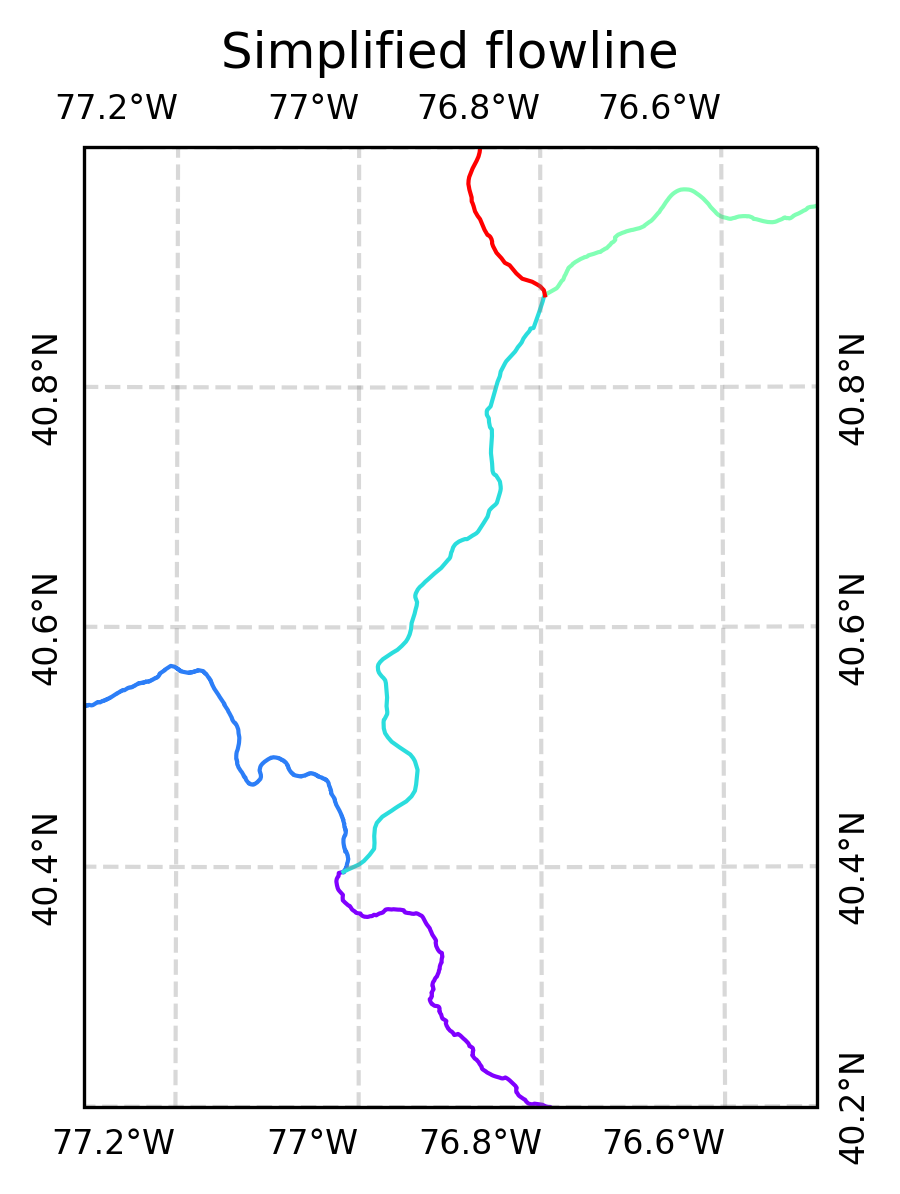

In [20]:
if iVisualization_method == 2:
    aExtent_confluence = [-77.3,-76.5, 40.2,41.0] 
    oPyflowline.plot( sVariable_in='flowline_simplified' , aExtent_in =aExtent_confluence ) 

Next, we will creata a mesh from the global MPAS mesh.

In [21]:
#run step 2
#we can either use a rectangle boundary
oPyflowline.iFlag_mesh_boundary = 0 #set to 0 to disable polygon-based
oPyflowline.dLongitude_left= -79
oPyflowline.dLongitude_right= -74.5
oPyflowline.dLatitude_bot= 39.20
oPyflowline.dLatitude_top= 42.8

aCell = oPyflowline.mesh_generation()

Start mesh generation.


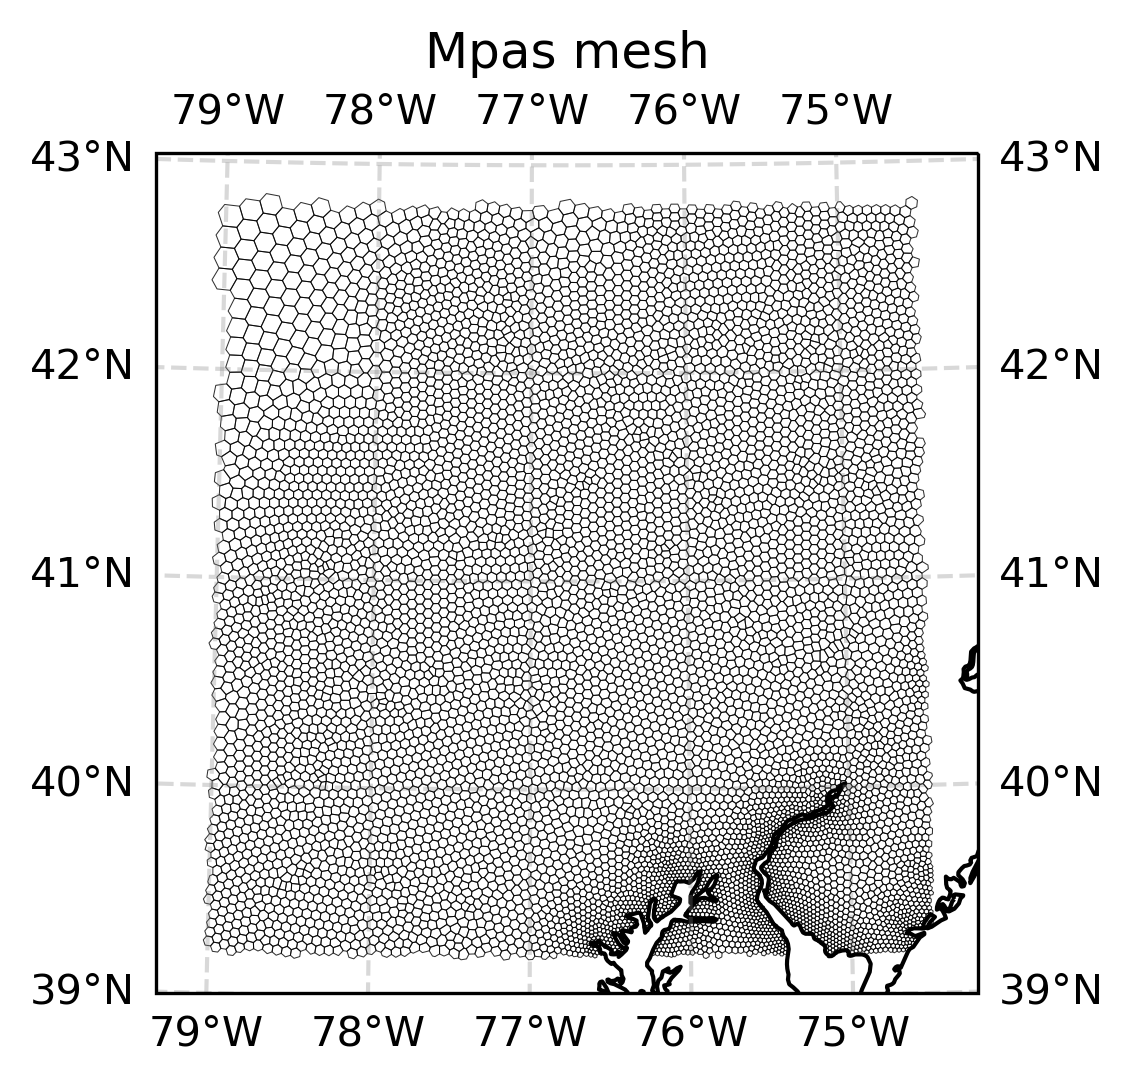

In [22]:
if iFlag_cartopy == 1: # you need to install the geopanda package and matplotlib package using conda or pip
    oPyflowline.plot( sVariable_in='mesh' ) 

else:
    
    import geopandas as gpd
    import matplotlib.pyplot as plt
    #use the geopanda package
    #the raw/original geojson file 
    sFilename_geojson = oPyflowline.aBasin[0].sFilename_mesh_geojson
    gdf = gpd.read_file(sFilename_geojson)
    gdf.plot()
    plt.show()

    pass

we can also use a polygon to create a mesh

In [23]:
oPyflowline.iFlag_mesh_boundary = 1
aCell = oPyflowline.mesh_generation()

Start mesh generation.


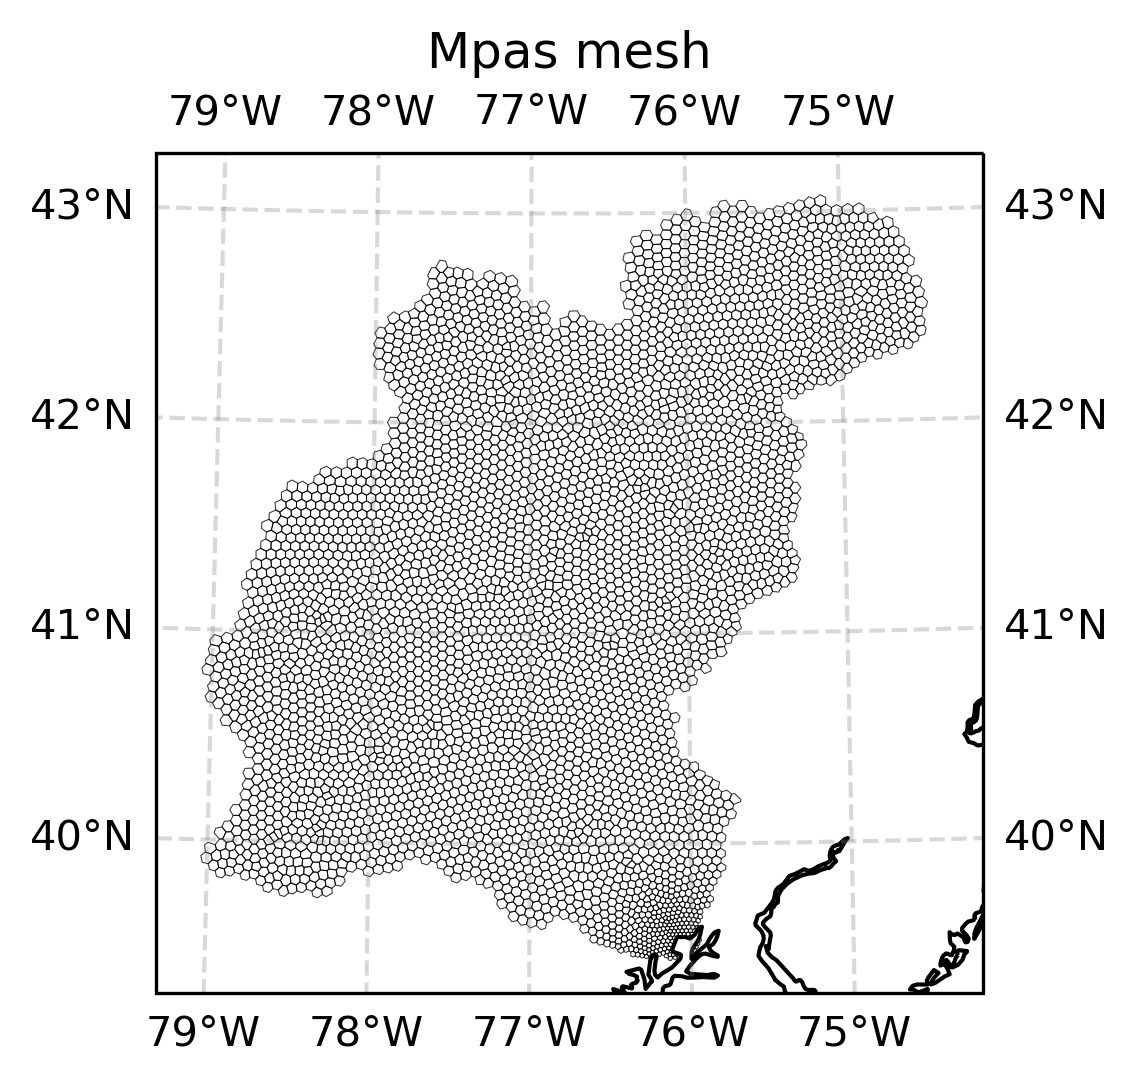

In [24]:
if iVisualization_method == 2:
    oPyflowline.plot( sVariable_in='mesh' ) 

Last, we can generate the conceptual flowline.

In [25]:
#runs step 3
oPyflowline.reconstruct_topological_relationship(aCell);

Start topology reconstruction.
Start topology reconstruction: 00000001
Elapsed time: 50.6966 seconds
Elapsed time: 0.1110 seconds
Elapsed time: 0.0008 seconds
Finish topology reconstruction: 00000001
Finish topology reconstruction.


Now we can overlap mesh with flowline.

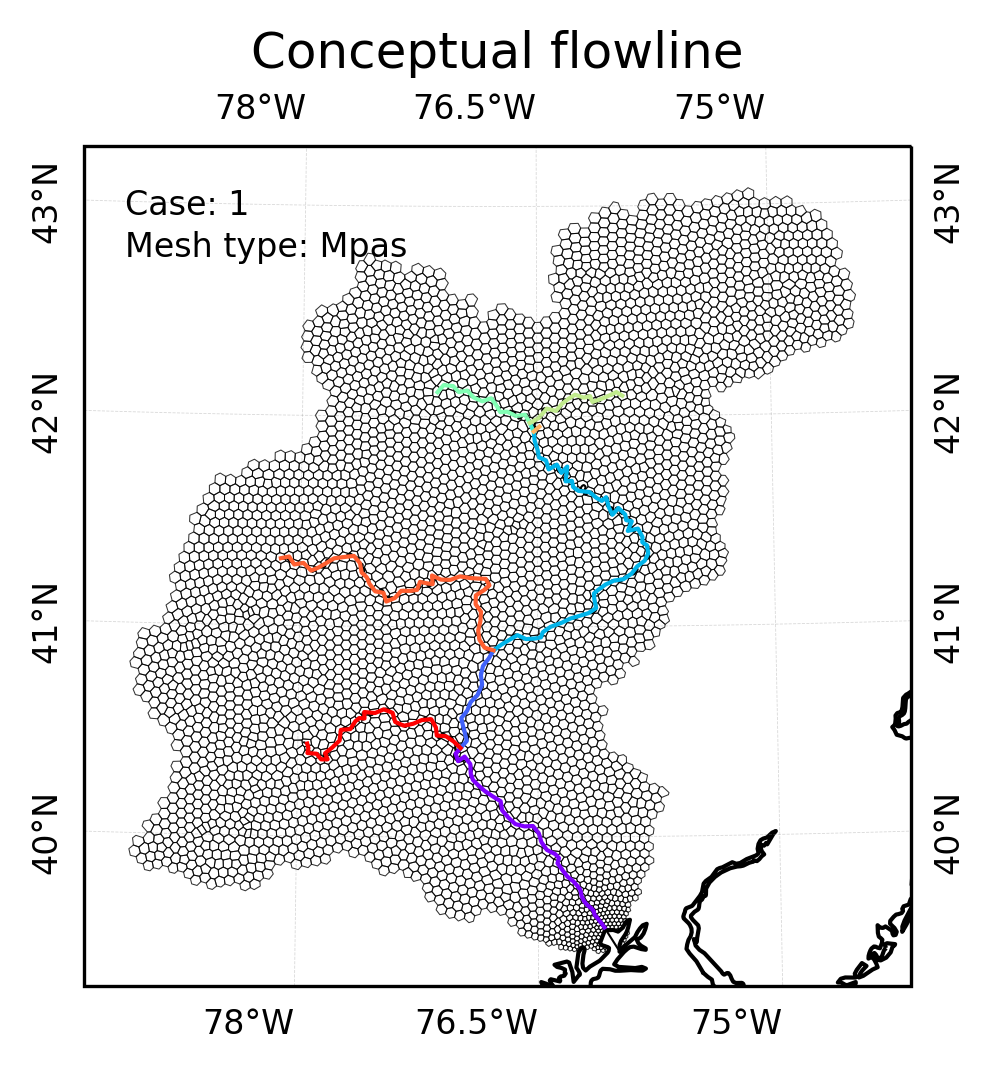

In [26]:

if iFlag_cartopy == 1: 
    oPyflowline.plot( sVariable_in='overlap') 
    pass
else:
    
    #
    file1_path = oPyflowline.aBasin[0].sFilename_mesh_geojson
    file2_path = oPyflowline.aBasin[0].sFilename_flowline_conceptual_geojson
    gdf1 = gpd.read_file(file1_path)
    gdf2 = gpd.read_file(file2_path)
    fig, ax = plt.subplots()
    gdf1.plot(ax=ax, color='blue')
    gdf2.plot(ax=ax, color='red')
    plt.show()
    pass

and take a close look at the outlet region

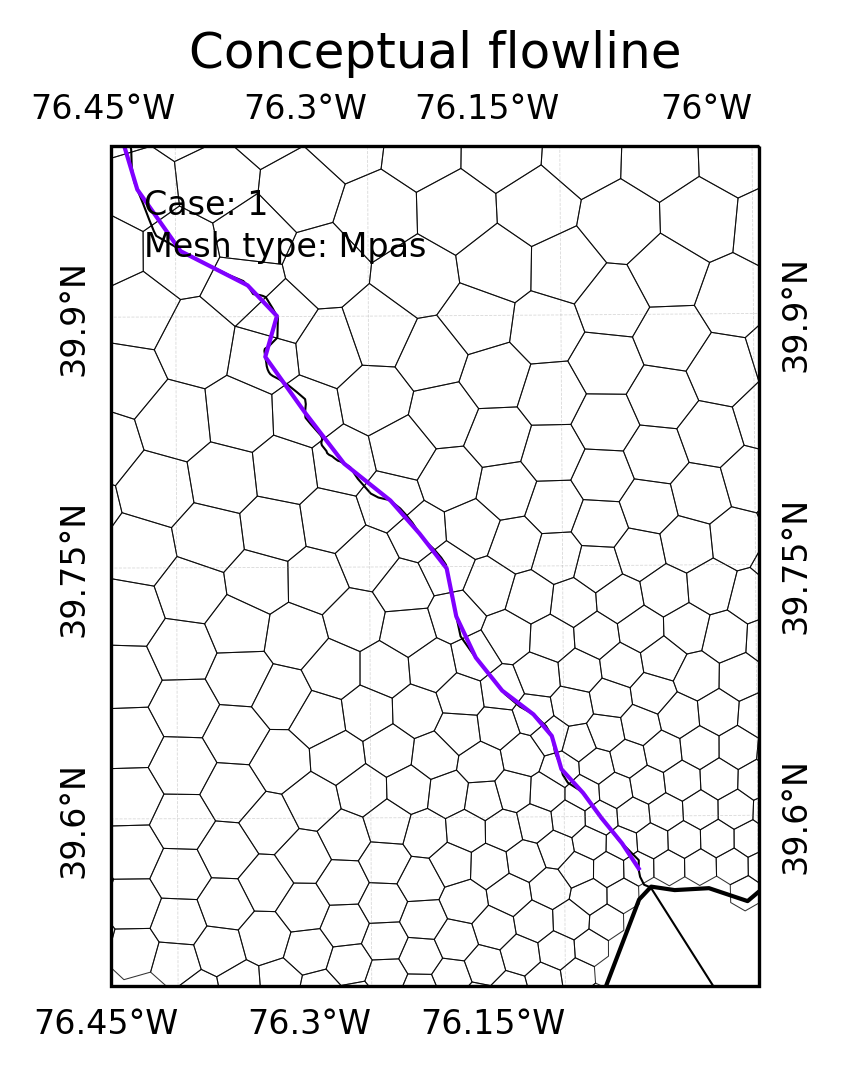

In [27]:
if iVisualization_method == 2:
    aExtent_outlet = [-76.0,-76.5, 39.5,40.0] #outlet
    oPyflowline.plot(sVariable_in='overlap' , aExtent_in =aExtent_outlet) 

After this, we can save the model output into a json file.

In [28]:
#export output
oPyflowline.export();

the content of the one of the exported json files can be checked:

In [32]:
with open(oPyflowline.sFilename_mesh_info, 'r') as pJSON:
    parsed = json.load(pJSON)
    print(json.dumps(parsed[0], indent=4))
    

{
    "aNeighbor": [
        50093,
        50092,
        50091,
        50089,
        50090,
        152720
    ],
    "aNeighbor_distance": [
        5295.051496048625,
        5165.067106140631,
        4704.415782842926,
        5318.332355136824,
        5162.141638508317,
        4709.218245189565
    ],
    "aNeighbor_land": [
        50093,
        50092,
        50091,
        50089,
        50090,
        152720
    ],
    "aVertex": [
        {
            "dLatitude_degree": 42.8069766748752,
            "dLongitude_degree": -75.9718524555715
        },
        {
            "dLatitude_degree": 42.8297240602518,
            "dLongitude_degree": -75.985349865291
        },
        {
            "dLatitude_degree": 42.830899574875,
            "dLongitude_degree": -76.0287301508959
        },
        {
            "dLatitude_degree": 42.8109729674047,
            "dLongitude_degree": -76.043387953159
        },
        {
            "dLatitude_degree": 42.7881222983663,
   

In [31]:
sFilename_flowline_conceptual_info= os.path.join(str(Path(oPyflowline.aBasin[0].sWorkspace_output_basin)  ), oPyflowline.aBasin[0].sFilename_flowline_conceptual_info  )    
                
with open(sFilename_flowline_conceptual_info, 'r') as pJSON:
    parsed = json.load(pJSON)
    print(json.dumps(parsed[0], indent=4))

{
    "dLength": 137418.4436364298,
    "iFlag_dam": 1,
    "iStream_order": 2,
    "iStream_segment": 9,
    "lIndex": 107,
    "nEdge": 36,
    "nVertex": 37,
    "pVertex_end": {
        "dLatitude_degree": 39.568704288614484,
        "dLongitude_degree": -76.09256864931575
    },
    "pVertex_start": {
        "dLatitude_degree": 40.423846901570556,
        "dLongitude_degree": -76.98298276752399
    }
}


The outlet associated flowline is always assigned with a dam, because it would be preserved.

Congratulations! You have successfully finished a pyflowline simulation.